# STEPS
1. Load data & Packages for model building & preprocessing
2. Preprocessing & Missing value imputation
3. Select Features on the basis of EDA conclusions & build baseline model.
4. Decide Evaluation Metric on the basis of business problem
5. Build model using all features and compare with the baseline
6. Use Reverse Feature Elimination to find the top features and build model using the top 10 features and compare

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
data = pd.read_csv("churn_prediction.csv")

In [4]:
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


In [5]:
data.shape

(28382, 21)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   days_since_last_transaction     25159 non-null  float64
 10  current_balance                 28382 non-null  float64
 11  previous_month_end_balance      28382 non-null  float64
 12  average_monthly_balance_prevQ   

In [7]:
# check for null values
data.isna().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [8]:
# 2 categorical variables 
# Gender and Occupation 
# Null values in Gender = 525
# Null values in Occupation = 80

In [9]:
#GENDER
data['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [10]:
dic_gender = {'Male':1,'Female':0}
data.replace({'gender': dic_gender}, inplace = True)
data['gender'] = data['gender'].fillna(-1)

In [11]:
data['gender'].value_counts()

 1.0    16548
 0.0    11309
-1.0      525
Name: gender, dtype: int64

In [12]:
#DEPENDENTS filling with the mode
data["dependents"].value_counts()
data['dependents'] = data['dependents'].fillna(0)

In [13]:
data['dependents'].value_counts()

0.0     23898
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
52.0        1
25.0        1
8.0         1
50.0        1
9.0         1
36.0        1
32.0        1
Name: dependents, dtype: int64

In [14]:
#OCCUPATION
# fill with the mode - sef_employed
data['occupation'] = data['occupation'].fillna('self_employed')
data['occupation'].value_counts()

self_employed    17556
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [15]:
#CITY
# fill with the mode
data['city'] = data['city'].fillna(1020)
data['city'].value_counts()

1020.0    4282
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
1601.0       1
1093.0       1
1313.0       1
1391.0       1
1174.0       1
Name: city, Length: 1604, dtype: int64

In [16]:
# DAYS_SINCE_LAST_TRANSACTION
# customer not done transaction for more than a year
data['days_since_last_transaction'] = data['days_since_last_transaction'].fillna(999)
data['days_since_last_transaction'].value_counts()

999.0    3223
0.0      1672
3.0       831
14.0      654
4.0       632
         ... 
134.0       1
288.0       1
183.0       1
218.0       1
321.0       1
Name: days_since_last_transaction, Length: 361, dtype: int64

In [17]:
data.columns

Index(['customer_id', 'vintage', 'age', 'gender', 'dependents', 'occupation',
       'city', 'customer_nw_category', 'branch_code',
       'days_since_last_transaction', 'current_balance',
       'previous_month_end_balance', 'average_monthly_balance_prevQ',
       'average_monthly_balance_prevQ2', 'current_month_credit',
       'previous_month_credit', 'current_month_debit', 'previous_month_debit',
       'current_month_balance', 'previous_month_balance', 'churn'],
      dtype='object')

In [18]:
data.isna().sum()

customer_id                       0
vintage                           0
age                               0
gender                            0
dependents                        0
occupation                        0
city                              0
customer_nw_category              0
branch_code                       0
days_since_last_transaction       0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
dtype: int64

In [19]:
#drop the customer_id -> since it is just a unique provider
data = data.drop(columns = 'customer_id')

In [20]:
data.describe()

,vintage,age,gender,dependents,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
count,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,28382.000000
mean,2364.336446,48.208336,0.564548,0.317102,802.444014,2.225530,925.975019,175.493341,7.380552e+03,7.495771e+03,7.496780e+03,7.124209e+03,3.433252e+03,3.261694e+03,3.658745e+03,3.339761e+03,7.451133e+03,7.495177e+03,0.185329
std,1610.124506,17.807163,0.531826,0.958386,428.316238,0.660443,937.799129,305.757315,4.259871e+04,4.252935e+04,4.172622e+04,4.457581e+04,7.707145e+04,2.968889e+04,5.198542e+04,2.430111e+04,4.203394e+04,4.243198e+04,0.388571
min,180.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-5.503960e+03,-3.149570e+03,1.428690e+03,-1.650610e+04,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,-3.374180e+03,-5.171920e+03,0.000000
25%,1121.000000,36.000000,0.000000,0.000000,409.000000,2.000000,176.000000,13.000000,1.784470e+03,1.906000e+03,2.180945e+03,1.832507e+03,3.100000e-01,3.300000e-01,4.100000e-01,4.100000e-01,1.996765e+03,2.074407e+03,0.000000
50%,2018.000000,46.000000,1.000000,0.000000,879.000000,2.000000,572.000000,41.000000,3.281255e+03,3.379915e+03,3.542865e+03,3.359600e+03,6.100000e-01,6.300000e-01,9.193000e+01,1.099600e+02,3.447995e+03,3.465235e+03,0.000000
75%,3176.000000,60.000000,1.000000,0.000000,1096.000000,3.000000,1440.000000,154.000000,6.635820e+03,6.656535e+03,6.666887e+03,6.517960e+03,7.072725e+02,7.492350e+02,1.360435e+03,1.357553e+03,6.667958e+03,6.654693e+03,0.000000
max,12899.000000,90.000000,1.000000,52.000000,1649.000000,3.000000,4782.000000,999.000000,5.905904e+06,5.740439e+06,5.700290e+06,5.010170e+06,1.226985e+07,2.361808e+06,7.637857e+06,1.414168e+06,5.778185e+06,5.720144e+06,1.000000


# PREPROCESSING

1. Keep all the features as numeric - one hot encoding for categorical variables
2. Scale the data 
    - log transform
    - StandardScalar

In [21]:
num_cols = ['current_balance','previous_month_end_balance', 
            'average_monthly_balance_prevQ2','average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 
            'current_month_debit','previous_month_debit',
            'current_month_balance', 'previous_month_balance']

for i in num_cols:
    data[i] = np.log(data[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [22]:
scaled

,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732
...,...,...,...,...,...,...,...,...,...,...
28377,-0.681476,-0.700548,-0.393466,-0.547552,-0.313909,-0.324466,-0.368230,-0.377369,-0.723081,-0.736426
28378,-0.220357,-0.201417,-0.213875,-0.308790,-0.313601,-0.324041,-0.181936,-0.163698,-0.266001,-0.283262
28379,4.233040,4.063636,1.897512,3.907073,0.585389,0.422031,-0.332759,-0.361886,4.144670,4.018282
28380,-0.584614,-0.603052,-0.556517,-0.656050,-0.313931,-0.324487,-0.368251,-0.377390,-0.623519,-0.636016


In [23]:
df_df_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [24]:
data.head()

,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,churn,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,3135,66,1.0,0.0,self_employed,187.0,2,755,224.0,0,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,310,35,1.0,0.0,self_employed,1020.0,2,3214,60.0,0,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,2356,31,1.0,0.0,salaried,146.0,2,41,999.0,0,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,478,90,-1.0,0.0,self_employed,1020.0,2,582,147.0,1,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,2531,42,1.0,2.0,self_employed,1494.0,3,388,58.0,1,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


In [25]:
# using dummies convert occupation to numeric


data_1 = pd.get_dummies(data['occupation'], prefix = str('occupation'), prefix_sep = '_')
data = data.drop(columns = 'occupation')
data = pd.concat([data, data_1], axis = 1)


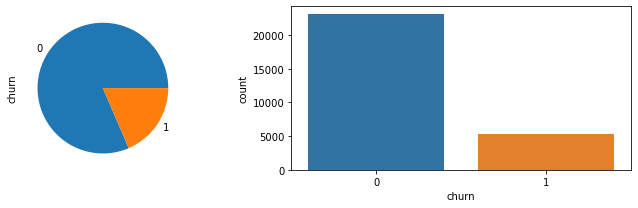

In [26]:
#EDA
# cchart for distribution of target variable
fig= plt.figure(figsize=(10,3) )
fig.add_subplot(1,2,1)
a= data["churn"].value_counts(normalize=True).plot.pie()
fig.add_subplot(1,2,2)
churnchart=sns.countplot(x=data["churn"])
plt.tight_layout()
plt.show()

<AxesSubplot:>

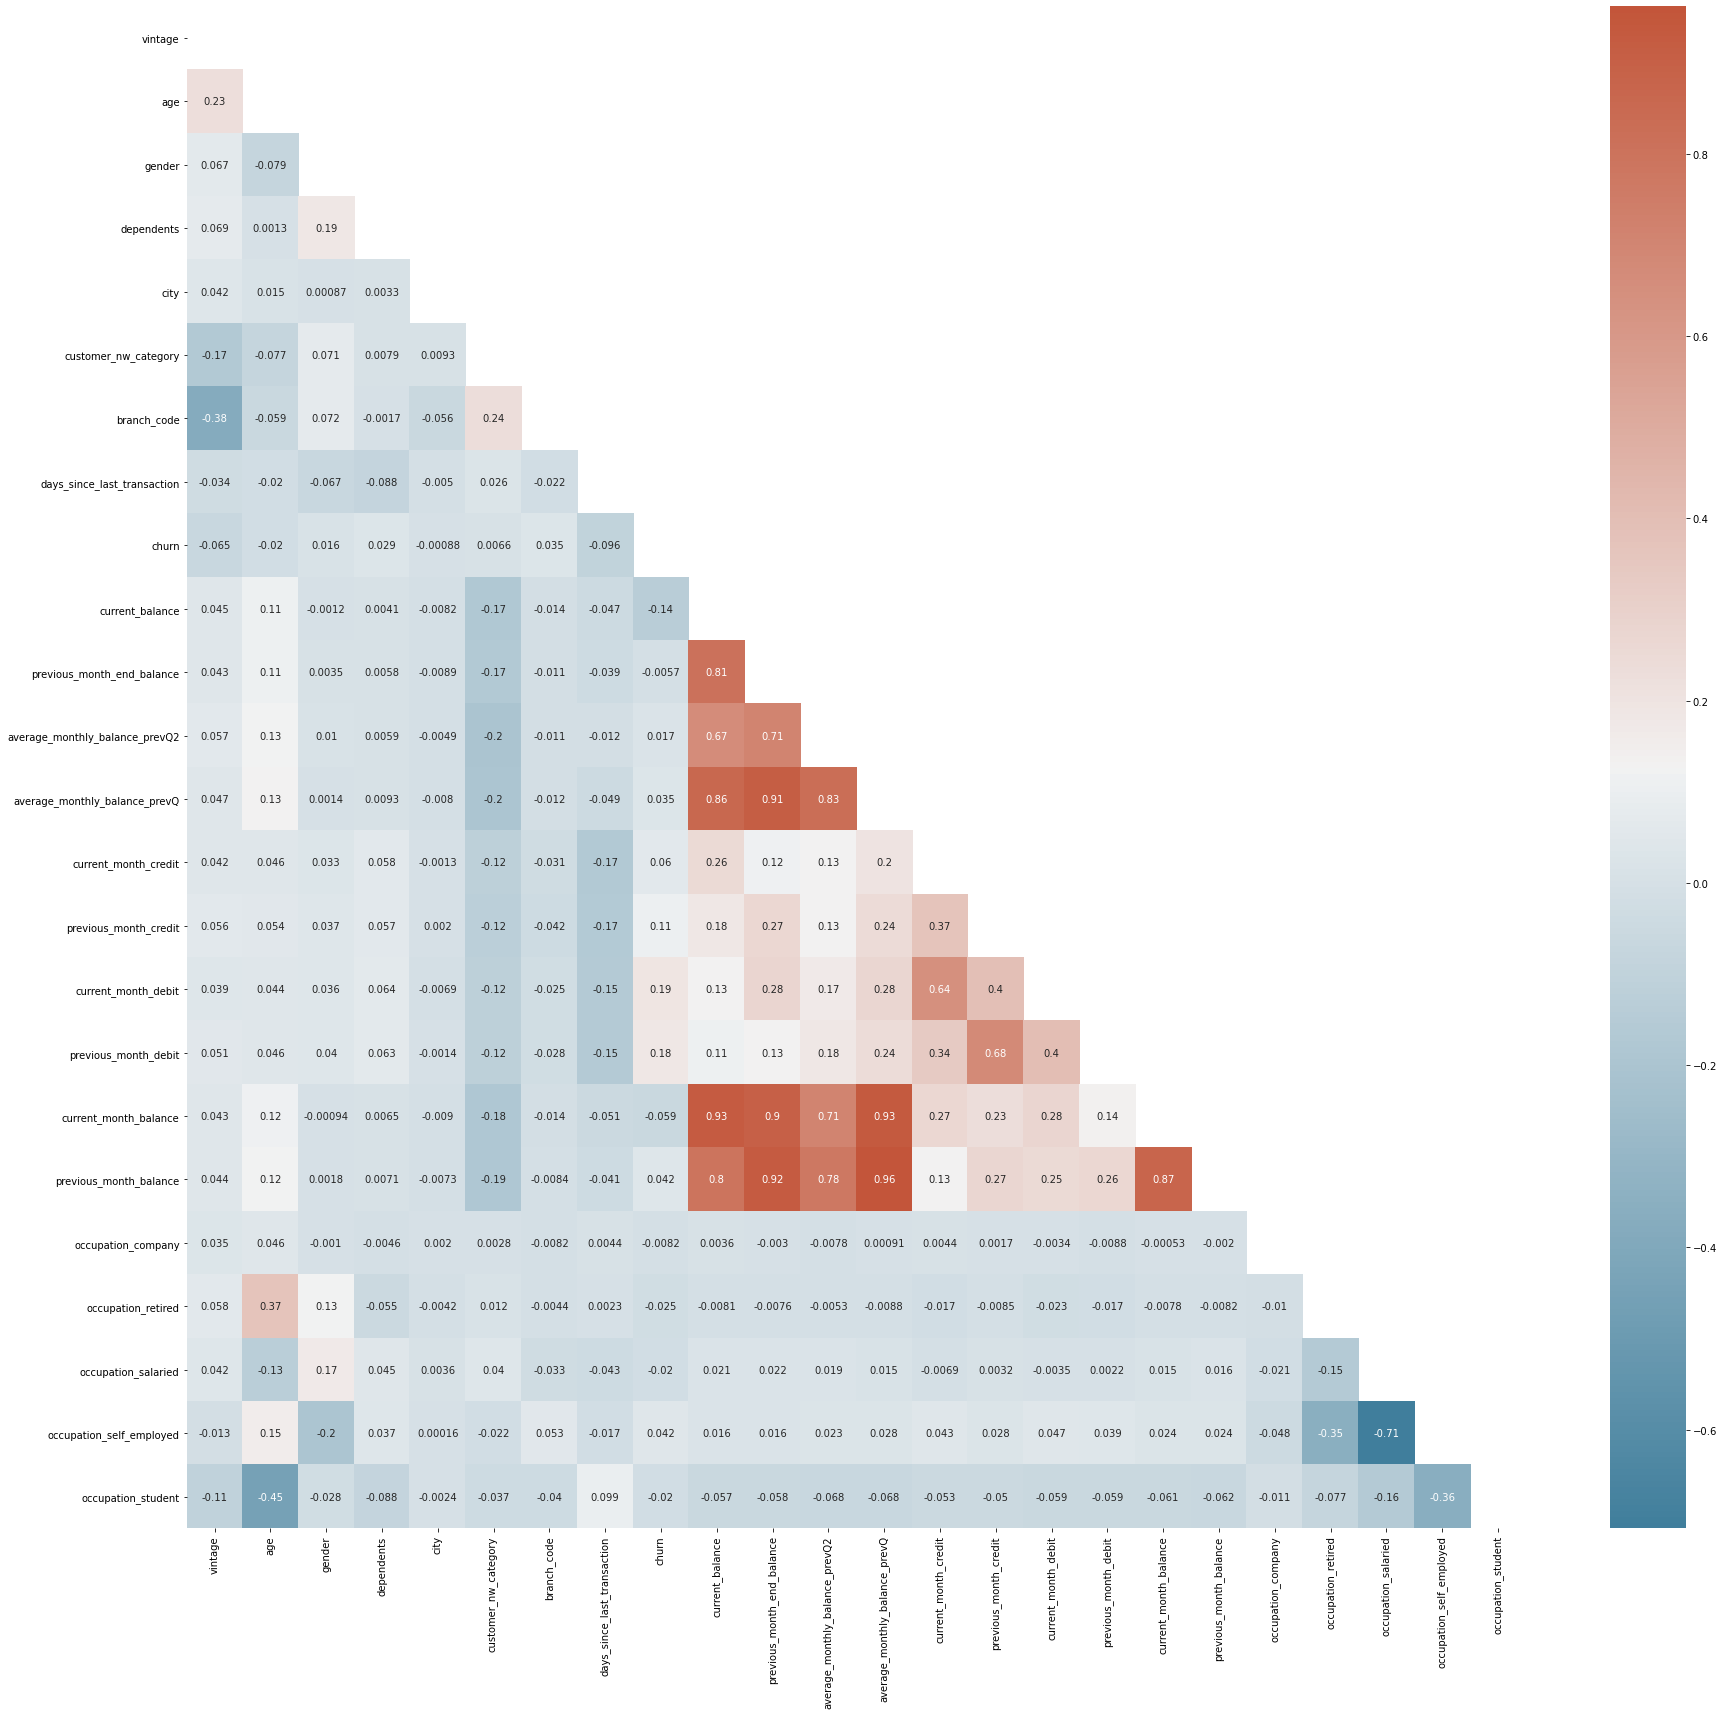

In [27]:
corr = data.corr()
f, ax = plt.subplots(figsize=(30,28))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [28]:
y = data['churn']
data = data.drop(['churn'], axis = 1)


In [29]:
data = data.drop(['city'],axis = 1)
data = data.drop(['customer_nw_category'],axis = 1)


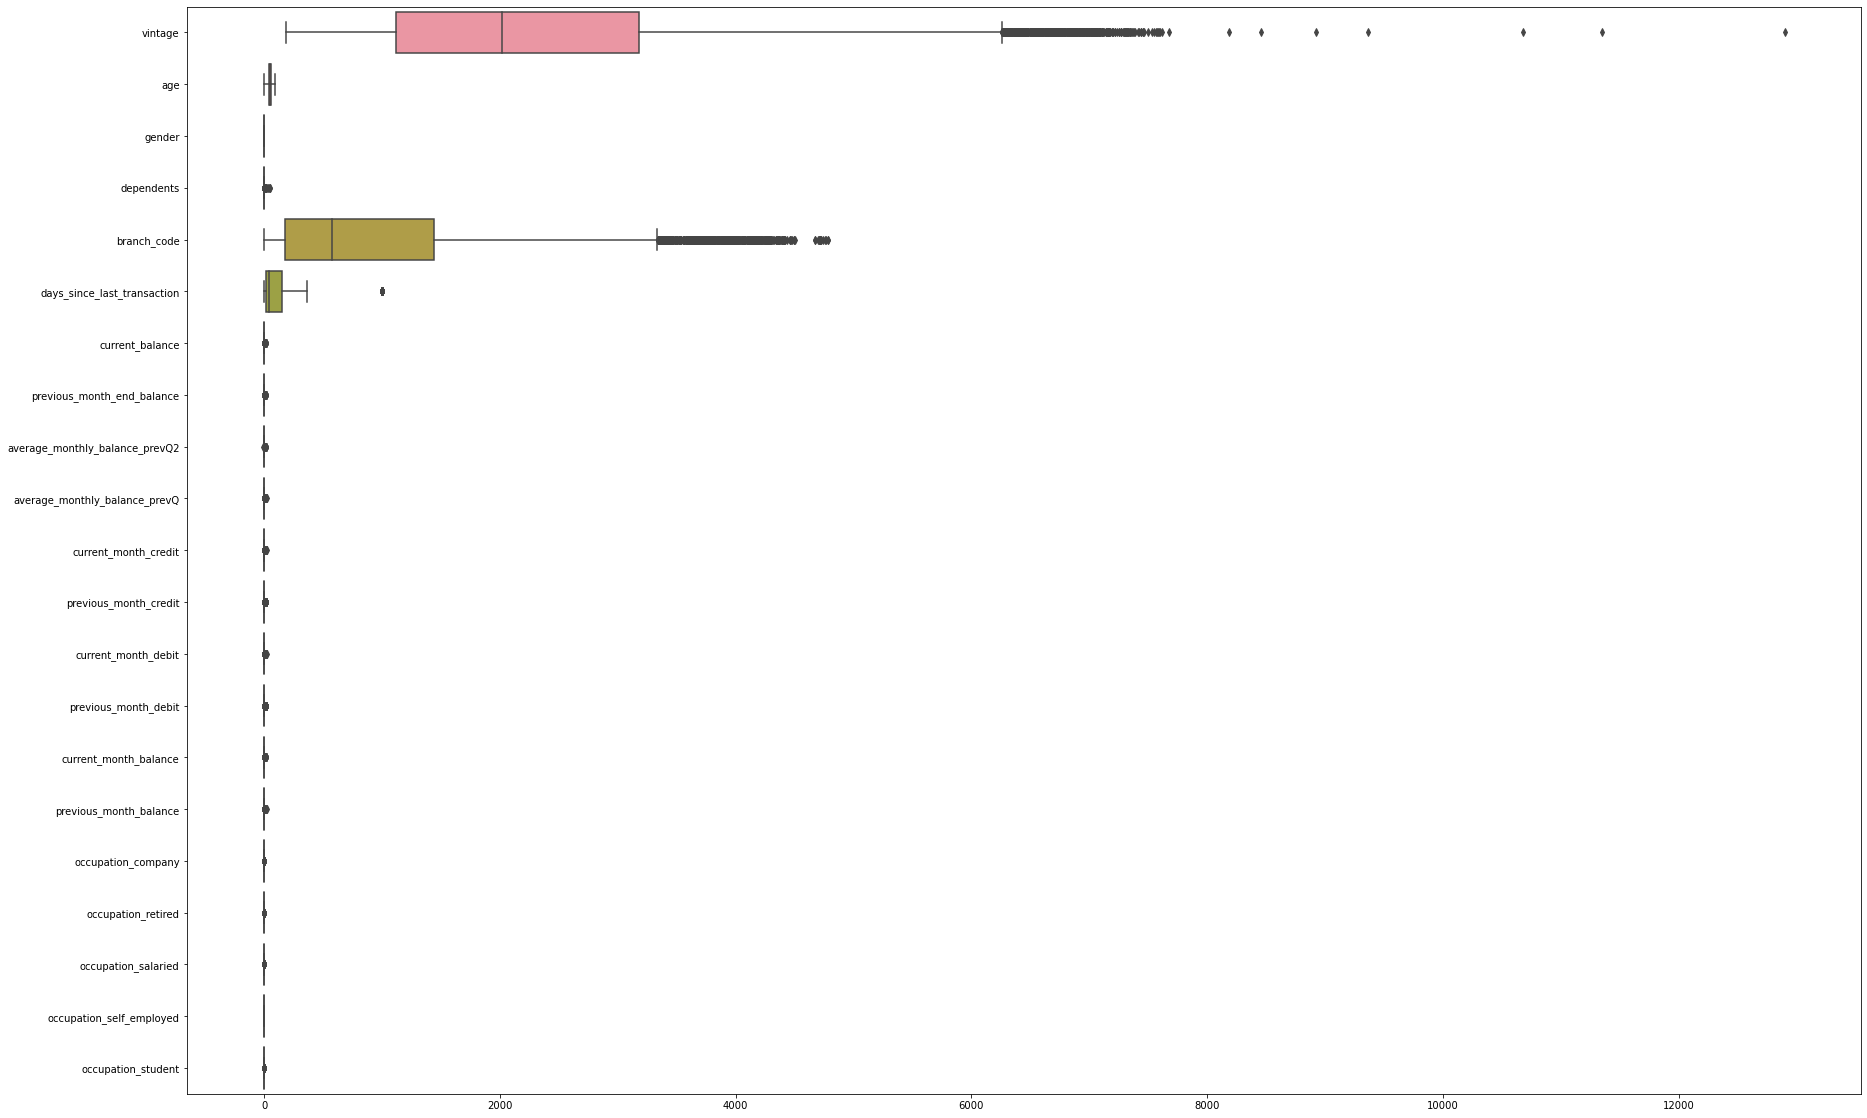

In [30]:
f, ax = plt.subplots(figsize=(30,20))
sns.boxplot( data = data, orient="h")

# display
plt.show()

In [31]:
data.head()

,vintage,age,gender,dependents,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,...,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,3135,66,1.0,0.0,755,224.0,-0.613738,-0.632367,-0.630646,-0.697612,...,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207,0,0,0,1,0
1,310,35,1.0,0.0,3214,60.0,0.011267,0.446458,0.949414,0.317595,...,-0.324410,0.640986,-0.355677,0.149440,0.455680,0,0,0,1,0
2,2356,31,1.0,0.0,41,999.0,-0.209651,0.057975,-0.388637,-0.108263,...,-0.324400,0.729825,-0.321607,-0.068597,-0.066642,0,0,1,0,0
3,478,90,-1.0,0.0,582,147.0,-0.470836,-0.488530,-0.712855,-0.582976,...,-0.324429,-0.368193,0.060593,-0.506570,-0.628056,0,0,0,1,0
4,2531,42,1.0,2.0,388,58.0,-0.708214,-0.642441,-0.554058,-0.663399,...,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732,0,0,0,1,0


# MODEL BUILDING AND EVALUATION METRICS
1. RECALL - If a customer who does not churn and if we predict that
 he churns, it is not a big problem for the bank -(False positive)
 If a customer churns and if we predict that he doesnt then
 that is problem for the bank -(False negatives)
2. AREA UNDER THE RECIEVER OPERATING CHARACTERISTIC CURVE (AUC- ROC)
 This is an evaluation metric for binary classification- Gives
 trade- off between True Positives and False Positives

In [32]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(data,y,test_size=1/3, random_state=11, stratify = y)

In [33]:
print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(18921, 21) (18921,)
(9461, 21) (9461,)


In [34]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]
pred

array([0.07505743, 0.16342464, 0.31158962, ..., 0.11660748, 0.29994709,
       0.15296507])

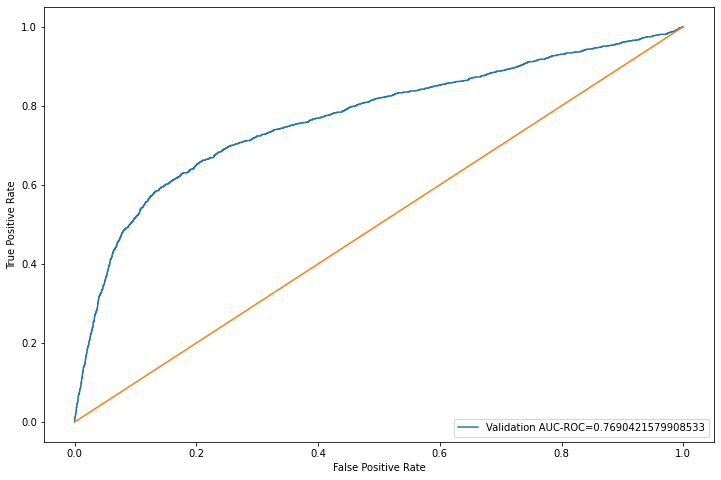

In [35]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [36]:
# Confusion Matrix
pred_val = model.predict(xtest)

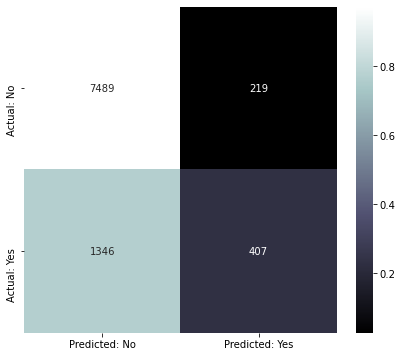

In [37]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)

def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm,
                    annot=cm,
                    fmt='g',
                    xticklabels=['Predicted: No','Predicted: Yes'],
                    yticklabels=['Actual: No','Actual: Yes'],
                    cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [38]:
# Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report")
report = classification_report(ytest, pred_val)
print(report)


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      7708
           1       0.65      0.23      0.34      1753

    accuracy                           0.83      9461
   macro avg       0.75      0.60      0.62      9461
weighted avg       0.81      0.83      0.80      9461



In [39]:
ytest.value_counts()

0    7708
1    1753
Name: churn, dtype: int64

In [40]:
#Recall Score

recall_score(ytest, pred_val)

0.23217341699942956

In [41]:
# Precision Score

precision_score(ytest, pred_val)

0.6501597444089456

# CROSS VALIDATION

In [42]:
from sklearn.metrics import classification_report
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = data.columns):
    i = 1
    cv_scores = []
    df1 = data.copy()
    df1 = data[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5, random_state=rstate, shuffle=True)
    
    for df_index,test_index in kf.split(df1,y):
        
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y.loc[df_index],y.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
    
        
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
        
         # Save scores
        cv_scores.append(roc_score)
        
        i+=1
    return cv_scores

In [43]:
data_scores = cv_score(LogisticRegression(), cols = data.columns)


1 of kfold 5
ROC AUC Score: 0.7731032781831261, Recall Score: 0.2053, Precision Score: 0.6835 

2 of kfold 5
ROC AUC Score: 0.7698339327921078, Recall Score: 0.1778, Precision Score: 0.6926 

3 of kfold 5
ROC AUC Score: 0.7654432733169314, Recall Score: 0.1901, Precision Score: 0.6601 

4 of kfold 5
ROC AUC Score: 0.7628045360953597, Recall Score: 0.1949, Precision Score: 0.6678 

5 of kfold 5
ROC AUC Score: 0.758139464128304, Recall Score: 0.1730, Precision Score: 0.6149 


# RANDOM FOREST

In [44]:
print(data.shape,y.shape)

(28382, 21) (28382,)


In [45]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(data,y,test_size=1/3, random_state=11, stratify = y)

In [46]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(18921, 21) (18921,)
(9461, 21) (9461,)


In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain,ytrain)
y_pred = rf.predict(xtest)

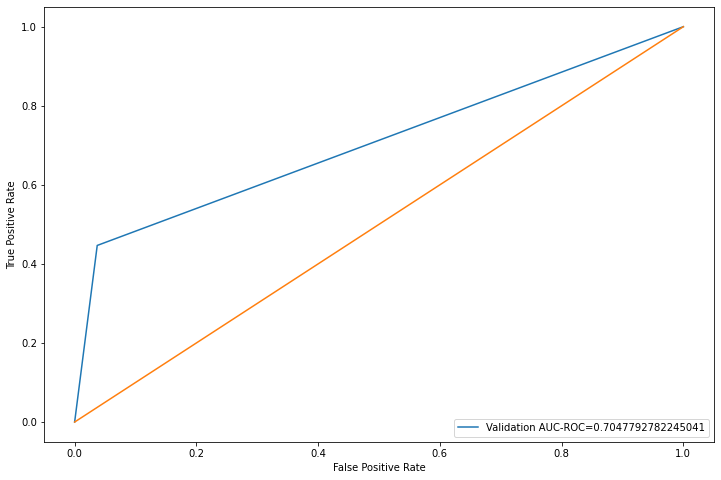

In [48]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,y_pred) 
auc = roc_auc_score(ytest, y_pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

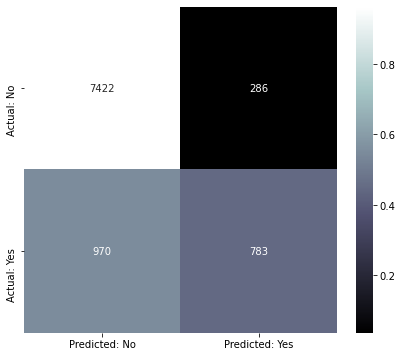

In [49]:
label_preds = y_pred

cm = confusion_matrix(ytest,label_preds)

def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm,
                    annot=cm,
                    fmt='g',
                    xticklabels=['Predicted: No','Predicted: Yes'],
                    yticklabels=['Actual: No','Actual: Yes'],
                    cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [50]:
# Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report")
report = classification_report(ytest, y_pred)
print(report)


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      7708
           1       0.73      0.45      0.55      1753

    accuracy                           0.87      9461
   macro avg       0.81      0.70      0.74      9461
weighted avg       0.86      0.87      0.85      9461



In [51]:
#Recall Score

recall_score(ytest, y_pred)

0.4466628636622932

In [52]:
#AUC-ROC Score

auc = roc_auc_score(ytest, y_pred)
print(auc)

0.7047792782245041


# XGBOOST

In [53]:
print(data.shape,y.shape)

(28382, 21) (28382,)


In [54]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(data,y,test_size=1/3, random_state=11, stratify = y)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(18921, 21) (18921,)
(9461, 21) (9461,)


In [55]:
import xgboost

In [56]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# fit model no training data
model = XGBClassifier()
model.fit(xtrain, ytrain)

# make predictions for test data
y_predxg = model.predict(xtest)


[17:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


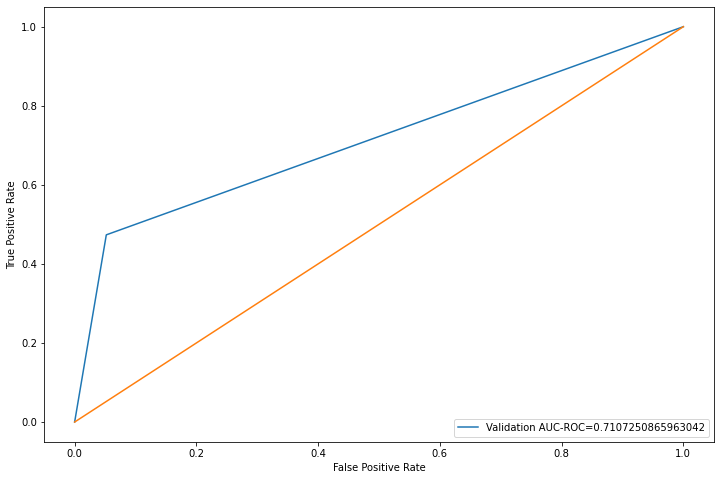

In [57]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,y_predxg) 
auc = roc_auc_score(ytest, y_predxg) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

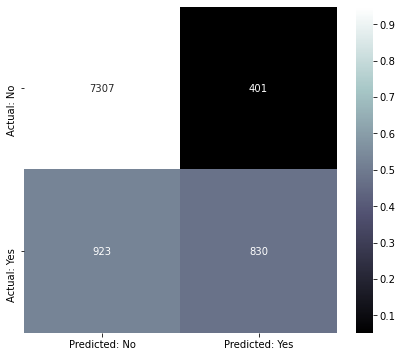

In [58]:
label_preds = y_predxg

cm = confusion_matrix(ytest,label_preds)

def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm,
                    annot=cm,
                    fmt='g',
                    xticklabels=['Predicted: No','Predicted: Yes'],
                    yticklabels=['Actual: No','Actual: Yes'],
                    cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [59]:
# Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report")
report = classification_report(ytest, y_predxg)
print(report)


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7708
           1       0.67      0.47      0.56      1753

    accuracy                           0.86      9461
   macro avg       0.78      0.71      0.74      9461
weighted avg       0.85      0.86      0.85      9461



In [60]:
#Recall Score

recall_score(ytest, y_predxg)

0.4734740444951512

In [61]:
#AUC-ROC Score

auc = roc_auc_score(ytest, y_predxg)
print(auc)

0.7107250865963042


# REVERSE FEATURE ELIMINATION OR BACKWARD SELECTION

In [480]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(data, y)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [481]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = data.columns
ranking_df['Rank'] = rfe.ranking_

In [482]:
ranked = ranking_df.sort_values(by=['Rank'])

In [483]:
ranked

,Feature_name,Rank
6,current_balance,1
9,average_monthly_balance_prevQ,2
16,occupation_company,3
8,average_monthly_balance_prevQ2,4
14,current_month_balance,5
15,previous_month_balance,6
12,current_month_debit,7
19,occupation_self_employed,8
18,occupation_salaried,9
20,occupation_student,10


In [487]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:12].values, thres=0.14)


1 of kfold 5
ROC AUC Score: 0.7987563456993114, Recall Score: 0.8203, Precision Score: 0.2898 

2 of kfold 5
ROC AUC Score: 0.8077184256499845, Recall Score: 0.8365, Precision Score: 0.2982 

3 of kfold 5
ROC AUC Score: 0.7993593517702315, Recall Score: 0.8241, Precision Score: 0.2979 

4 of kfold 5
ROC AUC Score: 0.7947442340837029, Recall Score: 0.8165, Precision Score: 0.2919 

5 of kfold 5
ROC AUC Score: 0.7947752756325075, Recall Score: 0.8127, Precision Score: 0.3062 


[0.7987563456993114,
 0.8077184256499845,
 0.7993593517702315,
 0.7947442340837029,
 0.7947752756325075]